# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = np.int32(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
def sobelKernel(I):
    Sx = np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape((3,3))
    Sy = Sx.T
    Ix = convolve2d(I, Sx)[1:-1,1:-1]
    Iy = convolve2d(I, Sy)[1:-1,1:-1]
    return Ix, Iy

In [3]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    Ix, Iy = sobelKernel(image)
    Ix2, Iy2, IxIy = Ix*Ix, Iy*Iy, Ix*Iy
    # Filtre 15x15 --> 2*3*sigma+1=15 <=> sigma = 7/3
    gaussianFilter = gaussianKernel((scale-1)/6)
    add = (scale-1)//2
    Ix2G, Iy2G, IxIyG = convolve2d(Ix2, gaussianFilter), convolve2d(Iy2, gaussianFilter), convolve2d(IxIy, gaussianFilter)
    Mtr = np.zeros(Ix.shape)
    Mdet = np.zeros(Ix.shape)
    for i in range(Mdet.shape[0]):
        for j in range(Mdet.shape[1]):
            m = np.array([Ix2G[i+add,j+add], IxIyG[i+add,j+add], IxIyG[i+add,j+add], Iy2G[i+add,j+add]]).reshape((2,2))
            Mdet[i,j] = np.linalg.det(m)
            Mtr[i,j] = np.trace(m)
    return Mdet - kappa*(Mtr*Mtr)
    

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

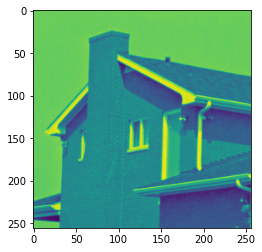

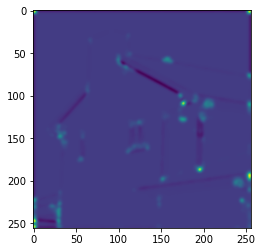

In [4]:
# %matplotlib notebook
house2 = np.array(Image.open('img/house2.png'))
plt.imshow(house2)
plt.show()
plt.imshow(computeR(house2,15,0.04))
plt.show()

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Le détecteur de Harris localise les points dont le voisinage correspond à au moins deux bords dans deux directions différentes. Par voisinage on entend ici les 8 points autours du point étudié. Ainsi en théorie, les surfaces et les bords ne sont pas détectés, et seul les coins sont valués plus ou moins haut selon les propriétés de leur entourage (cad si les bords des voisins sont plus ou moins prononcés).

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [5]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    return np.where(R>thres,1,0)

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [6]:
def rnms(R,thres):
    Rbin = thresholdR(R,thres)
    Rlocmax = np.zeros(R.shape)
    Rpad = np.pad(R,1)
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            val = R[i,j]
            if(Rbin[i,j] > 0 and val > np.max(Rpad[i:i+3,j]) and val > np.max(Rpad[i:i+3,j+2]) and val > Rpad[i,j+1] and val > Rpad[i+2,j+1]):
                Rlocmax[i,j] = 1
    return Rlocmax

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [7]:
def cornerDetector(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    return rnms(computeR(image,scale,kappa),thres)

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

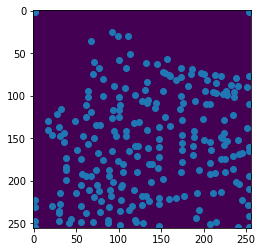

In [8]:
house2Corners = cornerDetector(house2,15,0.04,1e5)
corners = np.nonzero(house2Corners)
plt.imshow(house2Corners)
plt.scatter(corners[1], corners[0])
plt.show()

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

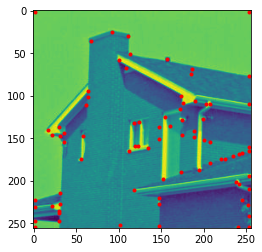

In [9]:
house2Corners = cornerDetector(house2,15,0.04,1e7)
corners = np.nonzero(house2Corners)
plt.imshow(house2)
plt.scatter(corners[1], corners[0], color='r', marker='.')
plt.show()

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

In [10]:
def displayCorners(img, imgCorners):
    nonZeros = np.nonzero(imgCorners)
    plt.imshow(img)
    plt.scatter(nonZeros[1], nonZeros[0], color='r', marker='.')
    plt.show()

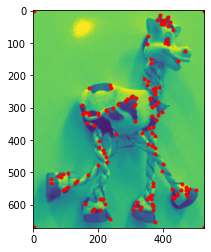

In [ ]:
toyHorse1 = np.array(Image.open('img/toyHorse1.png'))
toyHorse2 = np.array(Image.open('img/toyHorse2.png'))

toyHorse1Corners = cornerDetector(toyHorse1,15,0.04,1e8)
displayCorners(toyHorse1, toyHorse1Corners)

toyHorse2Corners = cornerDetector(toyHorse2,15,0.04,5e7)
displayCorners(toyHorse2, toyHorse2Corners)

2) What are the dynamic ranges of these two images ?

In [ ]:
minTH1 = np.min(toyHorse1) 
maxTH1 = np.max(toyHorse1)
minTH2 = np.min(toyHorse2) 
maxTH2 = np.max(toyHorse2)
print('La gamme dynamique de l\'image toyHorse1 est :', maxTH1-minTH1, ', de', minTH1, 'à', maxTH1)
print('La gamme dynamique de l\'image toyHorse2 est :', maxTH2-minTH2, ', de', minTH2, 'à', maxTH2)

3) What are the transformations beetween the two images ?

On remarque un changement de rotation et de luminosité.

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

In [ ]:
from scipy.ndimage import rotate

def normalizeImage(I, k1, k2):
    nI = I.copy()
    kmin = np.min(nI)
    kmax = np.max(nI)
    return np.floor((((nI-kmin)/(kmax-kmin))*(k2-k1))+k1).astype(int)

toyHorse1Corners = cornerDetector(toyHorse1,15,0.04,1e8)
displayCorners(toyHorse1, toyHorse1Corners)

rotated_toyHorse1 = rotate(toyHorse1, 24)
rotated_toyHorse1_corners = cornerDetector(rotated_toyHorse1,15,0.04,1e8)
displayCorners(rotated_toyHorse1, rotated_toyHorse1_corners)

normalized_toyHorse1 = normalizeImage(toyHorse1, np.min(toyHorse1), 180)
normalized_toyHorse1_corners = cornerDetector(normalized_toyHorse1,15,0.04,1e8)
nonZeros = np.nonzero(normalized_toyHorse1_corners)
plt.imshow(normalized_toyHorse1, vmin=0, vmax=255)
plt.scatter(nonZeros[1], nonZeros[0], color='r', marker='.')
plt.show()

toyHorse2Corners = cornerDetector(toyHorse2,15,0.04,1e8)
displayCorners(toyHorse2, toyHorse2Corners)

En observant les images, on remarque le fait d'appliquer une rotation sur l'image n'impacte pas la détection des coins. Mais le changement de luminosité a réduit le nombre de coins détectés.